In [1]:
import torch
from torchvision import models
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
import copy
import torch.nn.functional as F
import pickle

In [2]:
src_dir = "/home/hp/object_crops/"
backup_dir = "/home/hp/object_crops_backup/object_crops/"
val_dir = "/home/hp/object_crops_val/"

In [3]:
images = sorted( os.listdir(backup_dir) )

In [51]:
for i in range(len(images)):
    os.system("sudo cp " + backup_dir+images[i] + " "+ src_dir + images[i])

In [4]:
images = sorted( os.listdir(val_dir) )

In [11]:
obj_cnt = {}
unq = set()
cnt = 0
for i in range(len(images)):
    ind = images[i].rfind('f') - 1 
    if images[i][:ind] not in obj_cnt:
        obj_cnt[images[i][:ind]] = 1
        command = "sudo mv " + val_dir+images[i]+ " "+ val_dir+images[i][:ind] + "_1.jpg"
        unq.add(val_dir+images[i][:ind] + "_1.jpg")
        os.system(command)
        cnt += 1
    else:
        obj_cnt[images[i][:ind]] += 1
        command = "sudo mv " + val_dir+images[i]+ " "+ val_dir+images[i][:ind] + "_" + str(obj_cnt[images[i][:ind]])+".jpg"
        unq.add(val_dir+images[i][:ind] + "_" + str(obj_cnt[images[i][:ind]])+".jpg")
        os.system( command )
print(len(unq))

187


In [56]:
lst = []
for key,value in obj_cnt.items():
    lst.append(key)

In [58]:
random.shuffle(lst)

In [66]:
val_dir = "/home/hp/object_crops_val/"
images = os.listdir(src_dir)
for i in range(33):
    for img in images:
        if img.startswith(lst[i]):
            os.system("sudo mv "+src_dir+img + " " + val_dir+img)

In [3]:
print(len(os.listdir(src_dir)),len(os.listdir(val_dir)))

645 187


In [3]:
images_train = os.listdir(src_dir)
images_val = os.listdir(val_dir)
obj_cnt_train = {}
obj_cnt_val = {}

cnt = 0
for i in range(len(images_train)):
    ind = images_train[i].rfind('_') 
    if images_train[i][:ind] not in obj_cnt_train:
        obj_cnt_train[images_train[i][:ind]] = 1
        cnt += 1
    else:
        obj_cnt_train[images_train[i][:ind]] += 1
print(len(obj_cnt_train))        

cnt = 0
for i in range(len(images_val)):
    ind = images_val[i].rfind('_') 
    if images_val[i][:ind] not in obj_cnt_val:
        obj_cnt_val[images_val[i][:ind]] = 1
        cnt += 1
    else:
        obj_cnt_val[images_val[i][:ind]] += 1
print(len(obj_cnt_val))        

100
33


In [4]:
class IITKDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir,obj_cnt,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(self.root_dir)
        self.obj_details = []
        self.temp1 = []
        self.tem2 = []
        self.trans = transforms.ToTensor()
        
        for key,val in obj_cnt.items():
            self.obj_details.append([key,val])
        
    def __len__(self):
        return len(self.obj_details)

    def __getitem__(self, idx):
        random.shuffle(self.obj_details)
        
        img1 = self.obj_details[0]
        look = 1
        #print(img1[0][:7],self.obj_details[look][0][:7])
        while img1[0][:7] == self.obj_details[look][0][:7]:
            #print(img1[0][:7],self.obj_details[look][0][:7])
            look += 1
        img2 = self.obj_details[look]
        #print(img1,img2)
        
        self.temp1 = list(range(1,img1[1]+1))
        random.shuffle(self.temp1)
        
        self.temp2 = list(range(1,img2[1]+1))
        random.shuffle(self.temp2)
        
        sim1,sim2 = str(self.temp1[0]),str(self.temp1[1])
        image1 = Image.open(self.root_dir+img1[0]+"_"+sim1 + ".jpg")
        image2 = Image.open(self.root_dir+img1[0]+"_"+sim2+".jpg")
        
        diff = str(self.temp2[0])
        image3 = Image.open(self.root_dir + img2[0] + "_" + diff + ".jpg")
        
        image1,image2,image3 = image1,image2,image3
        return self.trans(image1),self.trans(image2),self.trans(image3)

In [5]:
def show_image_tensors(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot( np.ceil(n_images/float(cols)), cols,n + 1)
        #if image.ndim == 2:
        #    plt.gray()
        
    # Set the color channel as the third dimension
        image = image.numpy().transpose((1, 2, 0))
        # Clip the image pixel values
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [6]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    print("here")
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot( np.ceil(n_images/float(cols)), cols,n + 1)
        #if image.ndim == 2:
        #    plt.gray()
        
    # Set the color channel as the third dimension
        # Clip the image pixel values
        image = Image.open(image)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    print("here")
    plt.show()

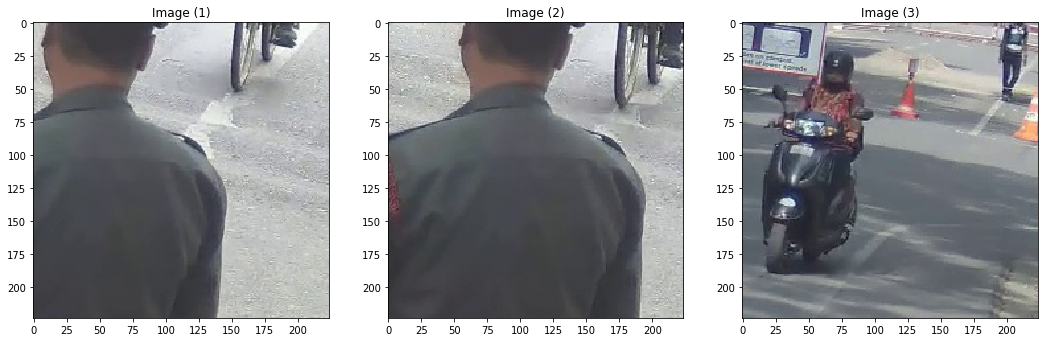

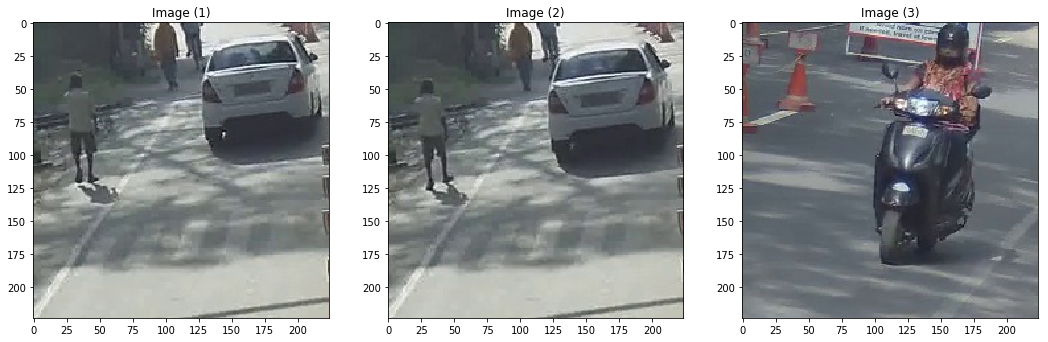

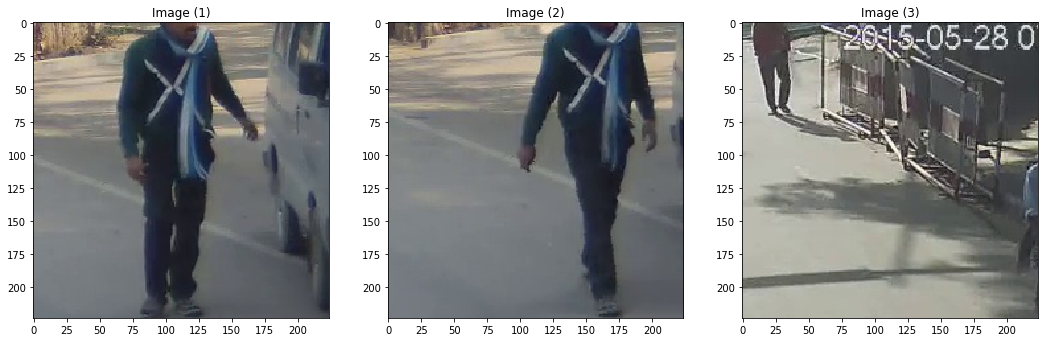

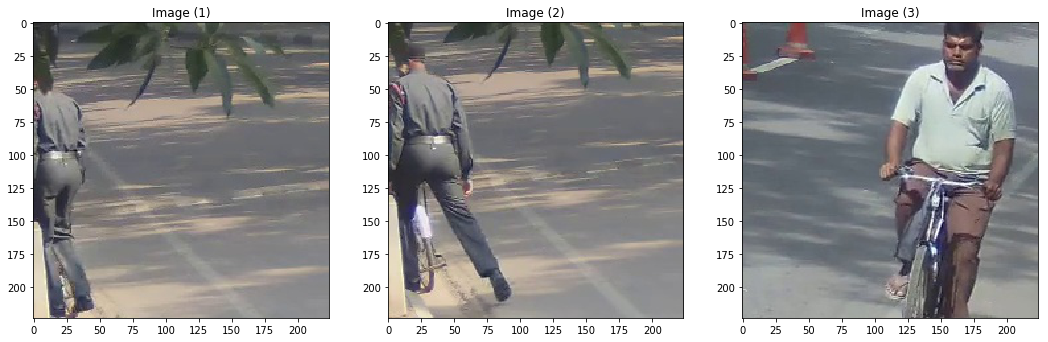

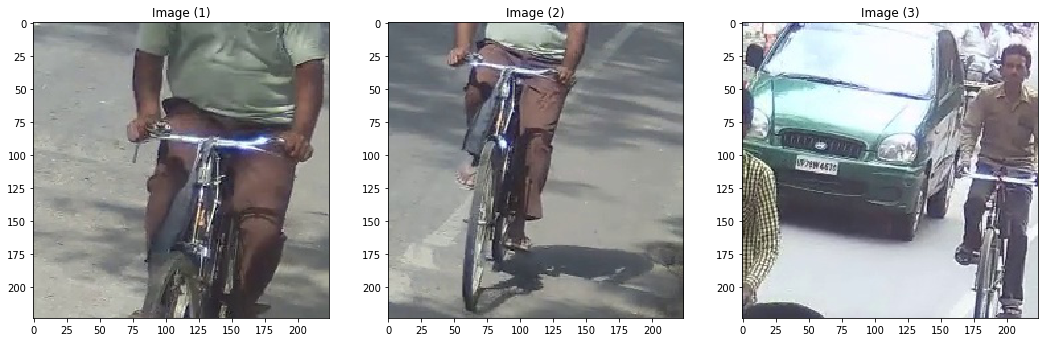

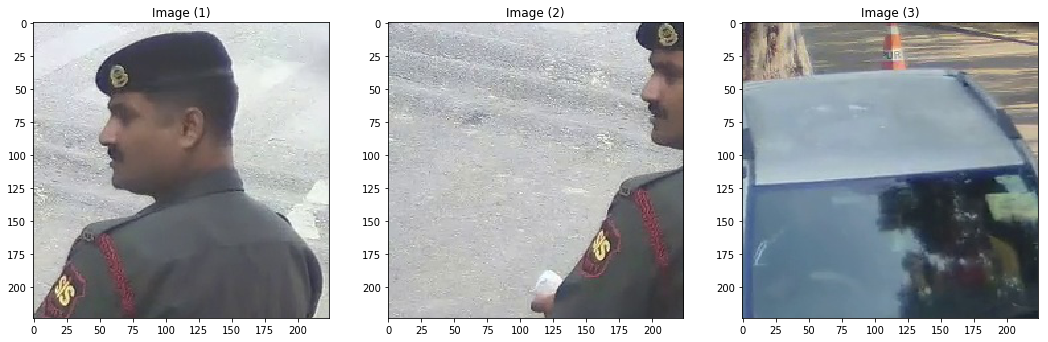

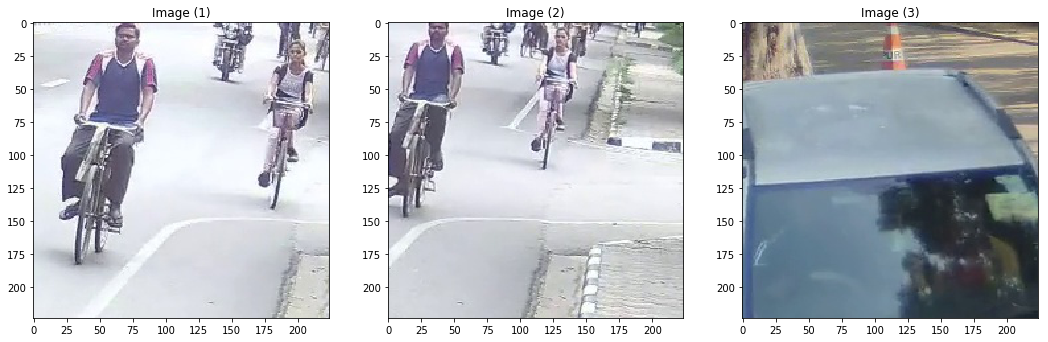

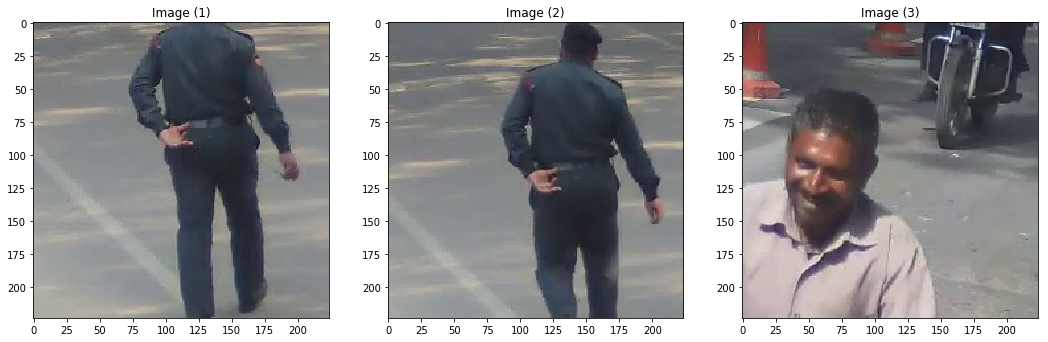

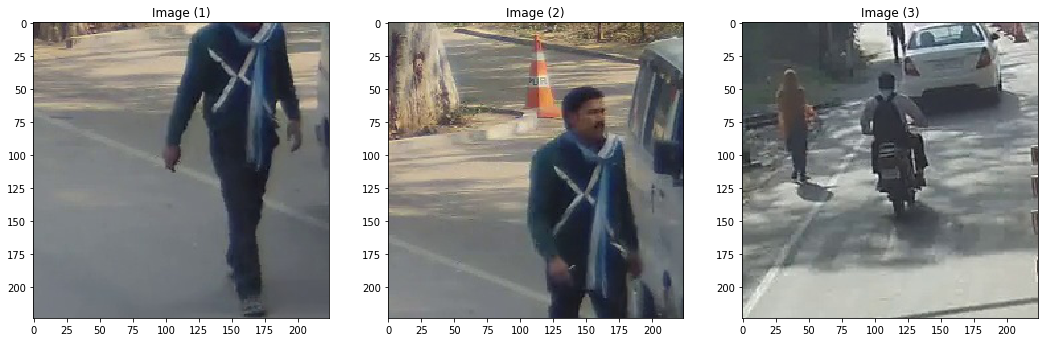

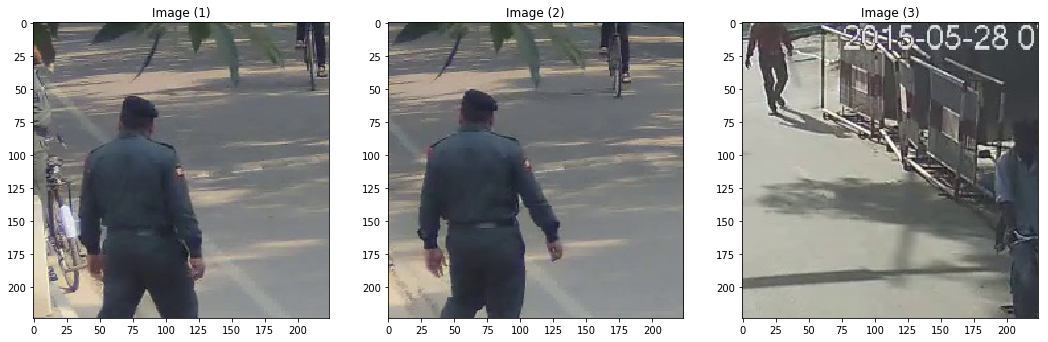

In [8]:
dset = IITKDataset(val_dir,obj_cnt_val)
for i in range(10):
    im1,im2,im3 = dset[i]
    show_image_tensors([im1,im2,im3],3)

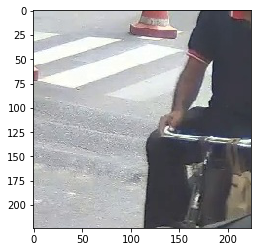

In [53]:
plt.imshow(Image.open(src_dir+"camera4_object_10_1.jpg"))

In [22]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin,weight):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.weight = weight

    def forward(self, anchor, positive, negative, size_average=True):
        #distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        #distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        distance_positive = 1 - torch.dot(anchor,positive)/(torch.norm(anchor)*torch.norm(positive))
        distance_negative = 1 - torch.dot(anchor,negative)/(torch.norm(anchor)*torch.norm(negative))
        losses = F.relu(distance_positive - self.weight*distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [52]:
a = torch.FloatTensor( [ [ [[1]],[[2]],[[3]] ],[ [[1]],[[2]],[[3]] ] ])
print(a.shape)

#a = a.view(2,3)
#print(a.shape)
(1 - torch.norm(a,dim=1)).sum()

torch.Size([2, 3, 1, 1])


tensor(-5.4833)

In [7]:
def train_model(model, dataloader,criterion, optimizer, num_epochs=10000):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs1,inputs2,inputs3 in dataloader:
            
            # zero the parameter gradients
            optimizer.zero_grad()
            inputs1,inputs2,inputs3 = inputs1.to(device), inputs2.to(device), inputs3.to(device)
            # forward
                # Get model outputs and calculate loss
            outputs1, outputs2, outputs3 = model(inputs1), model(inputs2), model(inputs3)
            #print(outputs1.shape)
            reg = 0.0
            """
            for elems in model.parameters():
                reg += (elems**2).sum()
            """
            loss = criterion(outputs1,outputs2,outputs3)


            # backward + optimize 
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs1.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(' Loss: {:.4f} '.format( epoch_loss))

            # deep copy the model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def train_model_new(model, dataloaders,criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            for inputs1,inputs2,inputs3 in dataloaders[phase]:
            
                # zero the parameter gradients
                optimizer.zero_grad()
                inputs1,inputs2,inputs3 = inputs1.to(device), inputs2.to(device), inputs3.to(device)
                # forward
                # Get model outputs and calculate loss
                """
                reg = 0.0
                
                for elems in model.parameters():
                    reg += (elems**2).sum()
                """
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs1, outputs2, outputs3 = model(inputs1), model(inputs2), model(inputs3)
                    print(outputs1.shape)
                    loss = criterion(outputs1,outputs2,outputs3) 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs1.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
train_dataset = IITKDataset(src_dir,obj_cnt_train)
val_dataset = IITKDataset(val_dir,obj_cnt_val)
dataloaders = {"train":DataLoader(train_dataset,batch_size=32),
               "val": DataLoader(val_dataset,batch_size=32)}
dataset_sizes = {"train": len(train_dataset),
                "val": len(val_dataset)}

In [27]:
for img1,img2,img3 in dataloaders["train"]:
    print(img1.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])


In [28]:
resnet = models.resnet18(pretrained = False)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
resnet_fe1 = nn.Sequential(*list(resnet.children())[:-1]).to(device)

In [31]:
#optimizer = optim.Adam(resnet_fe1.parameters(),lr=1e-5)
optimizer = optim.Adam(
    [
        {"params": resnet_fe1[0].parameters(), "lr": 1e-5},
        {"params": resnet_fe1[1].parameters(), "lr": 1e-5},
        {"params": resnet_fe1[4].parameters(),"lr":1e-5},
        {"params": resnet_fe1[5].parameters(),"lr":1e-5},
        {"params": resnet_fe1[6].parameters(),"lr":1e-4},
        {"params": resnet_fe1[7].parameters(),"lr":1e-4},
        
    ],
    lr=5e-4,
)


In [32]:
criterion = TripletLoss(0.5,1)

In [34]:
#resnet_fe.to(device)
criterion(torch.rand(10),torch.rand(10),torch.rand(10))

tensor(0.4742)

In [102]:
#torch.cuda.empty_cache()

In [9]:
resnet_fe1 = train_model_new(resnet_fe1,dataloaders,criterion,optimizer,10)

In [104]:
torch.save(resnet_fe1.state_dict(),"resnet_assign4_2.pth")

In [12]:
resnet = models.resnet18(pretrained=False)
resnet_fe = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet_fe.load_state_dict(torch.load("resnet_assign4_dl_final.pth"))

In [226]:
img = "camera1_object_5_frame_261.jpg"

In [13]:
transform = transforms.ToTensor()
test_dir = "/home/hp/test_object_crops/"
features = {}
resnet_fe.eval()
with torch.no_grad():
    for images in os.listdir(test_dir):
        img = transform(Image.open(test_dir+images))
        img = img.unsqueeze(0).to(device)
        out = resnet_fe(img)
        features[images] = out
torch.save(features,"train_features_ra42v.pkl")

In [36]:
transform = transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.ToTensor()
            ])
test_dir = "/home/hp/assign4_test/"
features = {}
resnet_fe.eval()
with torch.no_grad():
    for images in os.listdir(test_dir):
        print(images)
        img = transform(Image.open(test_dir+images))
        img = img.unsqueeze(0).to(device)
        out = resnet_fe(img)
        features[images] = out
torch.save(features,"test_features_2nd.pkl")

person7.jpg
cycle6.jpg
car4.jpg
cycle1.jpg
person2.jpg
cycle4.jpg
cycle7.jpg
person6.jpg
car1.jpg
person10.jpg
car11.jpg
car8.jpg
car2.jpg
person1.jpg
car7.jpg
person8.jpg
cycle3.jpg
car9.jpg
car6.jpeg
car3.jpg
person9.jpg
person3.jpg
cycle2.jpg
cycle5.jpg
car5.jpg
cycle8.jpg
person4.jpg
person5.JPG


(167, 512)
['camera5_object_52_frame_1026.jpg', 'camera5_object_30_frame_176.jpg', 'camera5_object_21_frame_166.jpg', 'camera5_object_18_frame_91.jpg', 'camera5_object_19_frame_116.jpg', 'camera5_object_28_frame_191.jpg', 'camera5_object_6_frame_46.jpg', 'camera5_object_24_frame_151.jpg', 'camera5_object_15_frame_56.jpg', 'camera5_object_19_frame_141.jpg']
(167,)
nearest neighbours of cycle - 
here
here


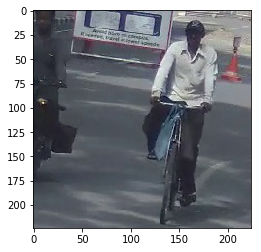

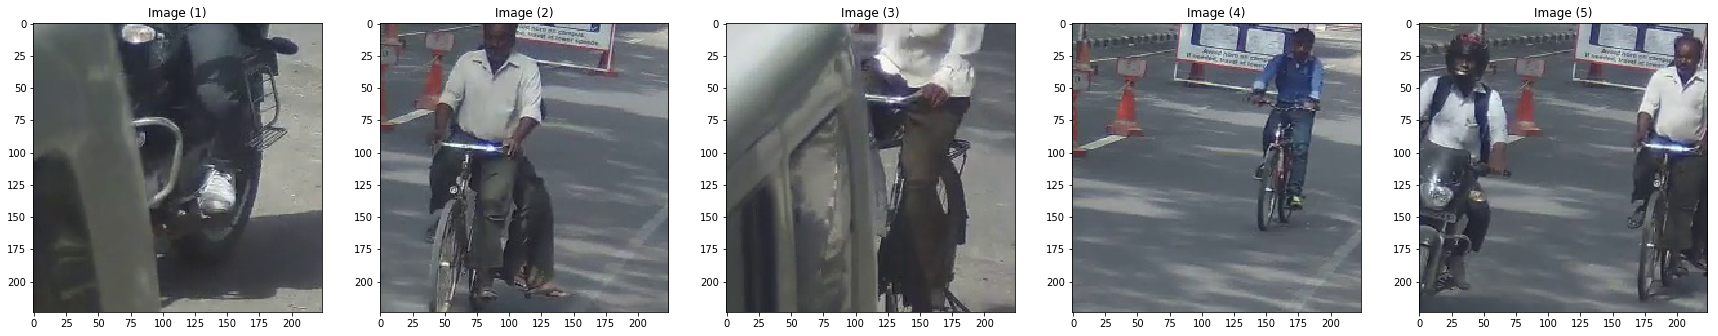

nearest neighbours of bike - 
here
here


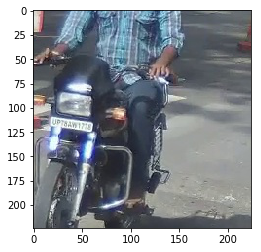

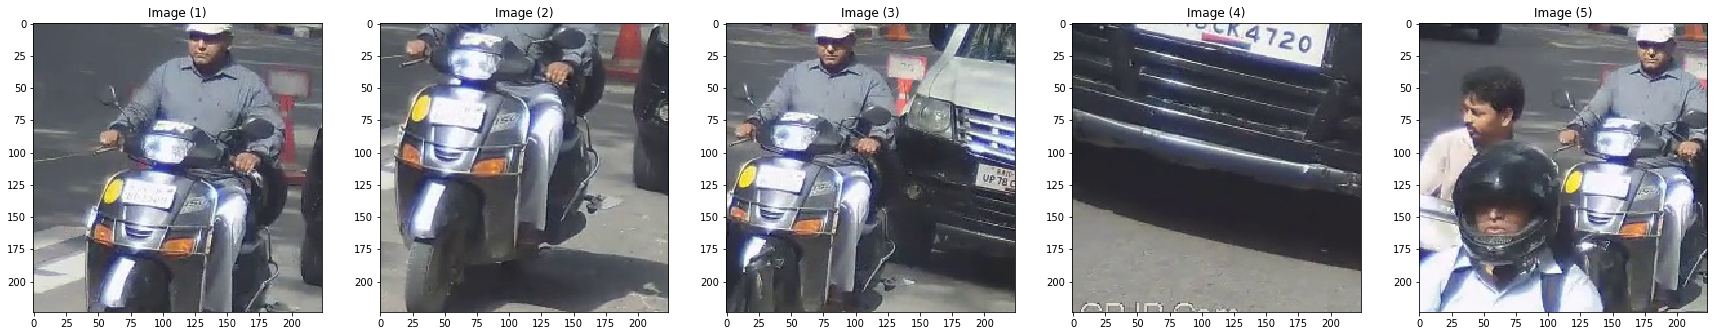

nearest neighbours of car - 
here
here


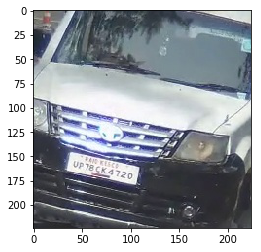

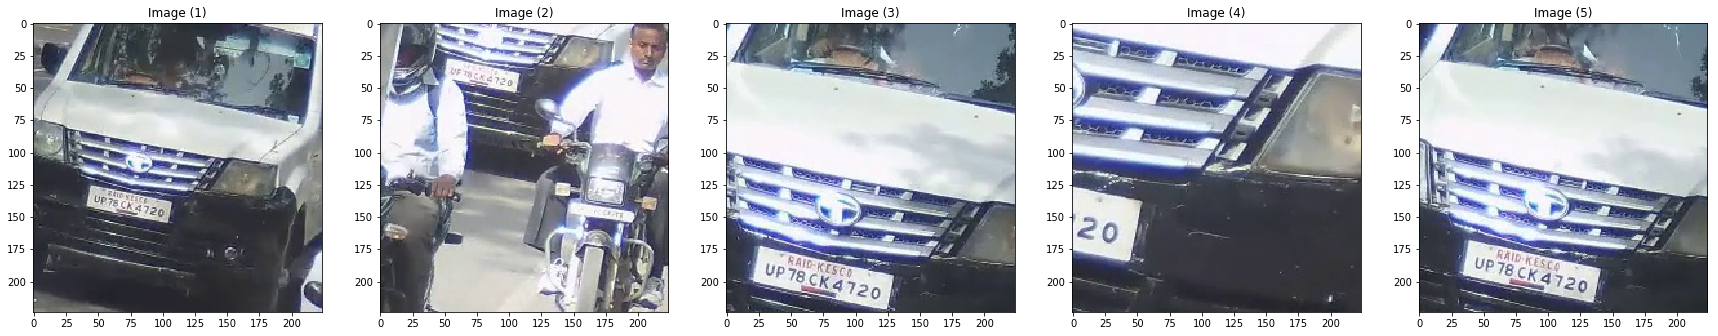

'\nprint("nearest neighbours of person - ")\nplt.imshow(Image.open(test_dir+person_frame))\ncnt = 0\nlst = []\nfor results in nn_person:\n    if not idx_to_key[results].startswith(person_frame[:16]):\n        lst.append(test_dir+idx_to_key[results])\n        cnt += 1\n        if cnt == 10:\n            break\n\nshow_images(lst,5)\n'

In [15]:
test_dir = "/home/hp/test_object_crops/"

features = torch.load("train_features_ra42v.pkl")

resnet_feature = []
key_to_idx = {}
idx_to_key = []

for i,(key,value) in enumerate(features.items()):
	resnet_feature.append(value.cpu().numpy().squeeze())
	key_to_idx[key] = i
	idx_to_key.append(key)

resnet_feature = np.array(resnet_feature,dtype=np.float32)
print(resnet_feature.shape)
print(idx_to_key[:10])
cycle_frame = "camera5_object_28_frame_176.jpg"
#cycle_frame = "cycle5.jpg"
#cycle_frame = "camera1_object_48_2.jpg"
#car_frame = "car2.jpg"
#car_frame = "camera3_object_20_4.jpg"
car_frame = "camera5_object_6_frame_46.jpg"
#person_frame = "person5.JPG"
#scooty_frame = "camera1_object_41_2.jpg"
bike_frame = "camera5_object_51_frame_1006.jpg"
#bike_frame = "camera1_object_28_5.jpg"
#person_frame = "camera2_object_51_3.jpg"


cycle = key_to_idx[cycle_frame]
#scooty = key_to_idx[scooty_frame]
bike = key_to_idx[bike_frame]
car = key_to_idx[car_frame]
#person = key_to_idx[person_frame]

nn_cycle = np.argsort(np.linalg.norm(resnet_feature - resnet_feature[cycle],axis=1))
#nn_scooty = np.argsort(np.linalg.norm(resnet_feature-resnet_feature[scooty],axis=1))
nn_bike = np.argsort(np.linalg.norm(resnet_feature - resnet_feature[bike],axis=1))
nn_car = np.argsort(np.linalg.norm(resnet_feature-resnet_feature[car],axis=1))
#nn_person = np.argsort(np.linalg.norm(resnet_feature-resnet_feature[person],axis=1))
print(nn_cycle.shape)


print("nearest neighbours of cycle - ")
cnt = 0
lst = []
plt.imshow(Image.open(test_dir+cycle_frame))
file_list = os.listdir(test_dir)

for results in nn_cycle:
    if not idx_to_key[results].startswith(cycle_frame[:17]):
        if idx_to_key[results] in file_list:
            lst.append(test_dir + idx_to_key[results])
        else:
            lst.append(val_dir+idx_to_key[results])
        cnt += 1
        if cnt == 10:
            break
show_images(lst[:5],5)
    
  
print("nearest neighbours of bike - ")
cnt = 0
lst = []
plt.imshow(Image.open(test_dir+bike_frame))
for results in nn_bike:
    if not idx_to_key[results].startswith(bike_frame[:17]):
        if idx_to_key[results] in file_list:
            lst.append(test_dir + idx_to_key[results])
        else:
            lst.append(val_dir + idx_to_key[results])
        
        cnt += 1
        if cnt == 10:
            break

show_images(lst[:5],5)


plt.imshow(Image.open(test_dir+car_frame))
print("nearest neighbours of car - ")
cnt = 0
lst = []
for results in nn_car:
    if not idx_to_key[results].startswith(car_frame[:16]):
        if idx_to_key[results] in file_list:
            lst.append(test_dir + idx_to_key[results])
        else:
            lst.append(val_dir + idx_to_key[results])
        cnt += 1
        if cnt == 10:
            break
show_images(lst[:5],5)

"""
print("nearest neighbours of person - ")
plt.imshow(Image.open(test_dir+person_frame))
cnt = 0
lst = []
for results in nn_person:
    if not idx_to_key[results].startswith(person_frame[:16]):
        lst.append(test_dir+idx_to_key[results])
        cnt += 1
        if cnt == 10:
            break

show_images(lst,5)
"""